# 영화 관객수 예측 모델 개발  

감독,이름,상영등급.스태프 수 등의 정보로 영화 관객 수를 예측하는 모델을 만들어 주세요!

**변수**

- title : 영화의 제목  
- distributor : 배급사  
- genre : 장르  
- release_time : 개봉일  
- time : 상영시간(분)  
- screening_rat : 상영등급  
- director : 감독이름  
- dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)  
- dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)  
- num_staff : 스텝수  
- num_actor : 주연배우수  
- box_off_num : 관객수

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import preprocessing 
from sklearn.model_selection import KFold

In [2]:
train=pd.read_csv("C:/Users/phl02/Desktop/P/Dacon-practice/영화 관객수/data/movies_train.csv")
test=pd.read_csv("C:/Users/phl02/Desktop/P/Dacon-practice/영화 관객수/data/movies_test.csv")
submission=pd.read_csv('C:/Users/phl02/Desktop/P/Dacon-practice/영화 관객수/data/submission.csv')

# EDA

## Data

In [3]:
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [4]:
train.shape

(600, 12)

In [5]:
test.shape

(243, 11)

## 결측값&정보

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  107 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


In [8]:
train.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [9]:
test.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

## 기술통계량

In [10]:
train.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.000000,2.700000e+02,600.000000,600.000000,600.000000,6.000000e+02
mean,100.863333,1.050443e+06,0.876667,151.118333,3.706667,7.081818e+05
std,18.097528,1.791408e+06,1.183409,165.654671,2.446889,1.828006e+06
min,45.000000,1.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
25%,89.000000,2.038000e+04,0.000000,17.000000,2.000000,1.297250e+03
50%,100.000000,4.784236e+05,0.000000,82.500000,3.000000,1.259100e+04
75%,114.000000,1.286569e+06,2.000000,264.000000,4.000000,4.798868e+05
max,180.000000,1.761531e+07,5.000000,869.000000,25.000000,1.426277e+07


## 장르별 관객수

In [11]:
train[['genre','box_off_num']].groupby('genre').mean().sort_values('box_off_num')

,box_off_num
genre,
뮤지컬,6.627000e+03
다큐멘터리,6.717226e+04
서스펜스,8.261100e+04
애니메이션,1.819267e+05
멜로/로맨스,4.259680e+05
미스터리,5.275482e+05
공포,5.908325e+05
드라마,6.256898e+05
코미디,1.193914e+06


## 상관계수

<AxesSubplot:>

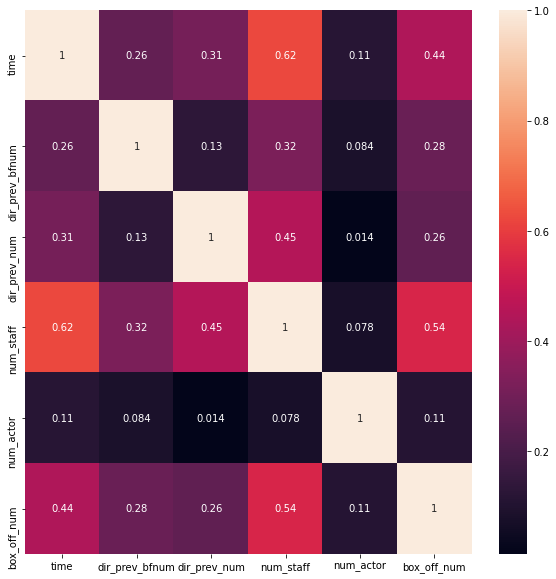

In [12]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(),annot=True)

스태프 수가 많을수록 관객수가 많아지는 경향  
시간이 길수록 관객수가 많아지는 경향  

## 전처리

해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수가 nan 결과가 나온 것 중에 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수, 즉 dir_prev_num를 보면 다 0임  
dir_prev_bfnum에 0으로 채울 것임

In [13]:
train[train['dir_prev_bfnum'].isna()]['dir_prev_num'].sum()

0

In [14]:
train['dir_prev_bfnum'].fillna(0,inplace=True)

In [15]:
train.isnull().sum()

title             0
distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
box_off_num       0
dtype: int64

In [16]:
test['dir_prev_bfnum'].fillna(0,inplace=True)

In [17]:
test.isnull().sum()

title             0
distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
dtype: int64

## 모델링

다른 부스팅 모델에 비해 속도가 빠름  
기존모델이 못 맞춘 문제에 가중치를 두어 지속적으로 학습을 이어나감

In [18]:
model=lgb.LGBMRegressor(random_state=777,n_estimators=1000)

In [19]:
features=['time','dir_prev_num','num_staff','num_actor']

In [20]:
target=['box_off_num']

In [21]:
x_train,x_test,y_train=train[features],test[features],train[target]

- ligjtGBM(base model)  
- k-fold lightGBM (k-fold model)  
- feature engineering (fe)  
- grid search (hyperparameter tuning)

In [22]:
model.fit(x_train,y_train)

LGBMRegressor(n_estimators=1000, random_state=777)

In [23]:
singleLGBM=submission.copy()
singleLGBM['box_off_num']=model.predict(x_test)
singleLGBM.to_csv('singleLGBM.csv',index=False)

관객수를 예측하는건데 음수가 있어서 잘못된 것을 바로 알 수 있음

## k-fold 교차검증  
과대적합 방지  

In [24]:
k_fold=KFold(n_splits=5,shuffle=True,random_state=777)

In [25]:
model=lgb.LGBMRegressor(random_state=777,n_estimators=1000)

In [26]:
models=[]
for train_idx,val_idx in k_fold.split(x_train):
    x_t=x_train.iloc[train_idx]
    y_t=y_train.iloc[train_idx]
    x_val=x_train.iloc[val_idx]
    y_val=y_train.iloc[val_idx]
    
    models.append(model.fit(x_t,y_t,eval_set=(x_val,y_val),early_stopping_rounds=100,verbose=100))    

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's l2: 2.70572e+12
[100]	valid_0's l2: 3.90847e+12
[100]	valid_0's l2: 3.50344e+12
[100]	valid_0's l2: 1.45977e+12
[100]	valid_0's l2: 1.77214e+12


validation set은 eval_set에 넣어주면 됨  
계속 반복하다가 일정수준에 도달한 다음에도 계속 학습을 하면 과적합이 될 수 있어서 학습을 중단시켜야 할 필요가 있는데 그 중단시키는 역할은 early_stopping_rounds가 함.   
100번의 과정에서 모델의 오차율이 범위 내에서 감소하지 않으면 스탑!  
평가는 validation으로 함  
verbose는 100번 마다 모델 값을 보여달라는 의미 

In [27]:
preds=[]
for model in models:
    preds.append(model.predict(x_test))
len(preds)

5

In [28]:
kfoldLGBM=submission.copy()
kfoldLGBM['box_off_num']=np.mean(preds,axis=0)
kfoldLGBM.to_csv('kfoldLGBM.csv',index=False)

## feature engineering

문자열로 되어 있어서 숫자로 변환

In [29]:
le=preprocessing.LabelEncoder()
train['genre']=le.fit_transform(train['genre'])

In [30]:
test['genre']=le.transform(test['genre'])

In [31]:
features.append('dir_prev_bfnum')
features.append('genre')
features

['time', 'dir_prev_num', 'num_staff', 'num_actor', 'dir_prev_bfnum', 'genre']

In [32]:
x_train,x_test,y_train=train[features],test[features],train[target]

In [33]:
models=[]
for train_idx,val_idx in k_fold.split(x_train):
    x_t=x_train.iloc[train_idx]
    y_t=y_train.iloc[train_idx]
    x_val=x_train.iloc[val_idx]
    y_val=y_train.iloc[val_idx]
    
    models.append(model.fit(x_t,y_t,eval_set=(x_val,y_val),early_stopping_rounds=100,verbose=100))    

[100]	valid_0's l2: 2.62067e+12
[100]	valid_0's l2: 4.39227e+12
[100]	valid_0's l2: 3.29841e+12
[100]	valid_0's l2: 1.56499e+12
[100]	valid_0's l2: 1.60118e+12


In [34]:
preds=[]
for model in models:
    preds.append(model.predict(x_test))
len(preds)

5

In [35]:
feLGBM=submission.copy()
feLGBM['box_off_num']=np.mean(preds,axis=0)
feLGBM.to_csv('feLGBM.csv',index=False)